<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/Kaggle/2023Q2/Un_primer_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import cupy as cp
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split





In [2]:

X_train_OG=pd.read_csv('dataset/train.csv')

X_train_OG.fillna(0, inplace=True)


y_train_OG = X_train_OG.averageRating


X_train_OG.drop(['averageRating'], axis=1, inplace=True)



X_pred=pd.read_csv('dataset/val.csv')
X_pred.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_OG, y_train_OG, test_size=0.1, random_state=881)

#Show difference between train and test by columns
#make a set of the columns that are in train but not in test
""" 
print(set(X.columns))
# Train the model on the GPU

"""

' \nprint(set(X.columns))\n# Train the model on the GPU\n\n'

In [ ]:
best_score = 0
best_random = 0
best_regr = None
randoms=set()
scores = []
for random in range(0, 20):
    random = np.random.randint(0, 1000)
    while random in randoms:
        random = np.random.randint(0, 1000)
    randoms.add(random)

    X_train, X_test, y_train, y_test = train_test_split(X_train_OG, y_train_OG, test_size=0.1, random_state=random)
    regr = XGBRegressor(n_estimators=1100,eta=0.025,
                        max_depth=19,gamma = 0.05,
                        colsample_bytree = 0.7,colsample_bylevel=0.7,colsample_bynode=0.8,
                        tree_method = 'hist',
                        max_cached_hist_node=262144) # type: ignore
    #regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
    print("Training a XGBRegressor")
    regr.fit(X_train, y_train)
    print("Finished training the XGBRegressor")

    score = regr.score(X_test, y_test)

    print(f"R^2 score on testing {random} data: {score:.4f}") 
    scores.append(score)
    if score > best_score:
        best_score = score
        best_random = random
        best_regr = regr
    # 881 ~ 0.5570
    # 791 ~ 0.5458
    # 104 ~ 0.5386
    # 0.942872
""" 
      """

In [8]:
regr = XGBRegressor(n_estimators=2000,eta=0.025,
                        max_depth=20,gamma = 0.20,
                        colsample_bytree = 0.7,colsample_bylevel=0.7,colsample_bynode=0.8,
                        tree_method = 'hist',
                        max_cached_hist_node=262144) # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train, y_train)
print("Finished training the XGBRegressor")

score = regr.score(X_test, y_test)

print(f"R^2 score on testing data: {score:.4f}") 
# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
#print(set(X_pred.columns)) 5528

Training a XGBRegressor
Finished training the XGBRegressor
R^2 score on testing data: 0.5528
RMSE: 0.942390


In [ ]:
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_squared_error



# Create a linear support vector machine regressor object with parallel processing
svr = LinearSVR(C=1.0, epsilon=0.1, max_iter=1000, dual=False, random_state=42, verbose=1, n_jobs=-1)

# Train the model on the training set
svr.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svr.predict(X_test)

# Evaluate the model using root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

In [ ]:
regr = best_regr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

# Normalize the data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_norm.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
model.fit(X_train_norm, y_train, epochs=100, batch_size=32, validation_data=(X_test_norm, y_test),workers=16)




In [ ]:

# Evaluate the model
X_test = scaler.transform(X_test)
score = model.evaluate(X_test, y_test)
print("MSE on testing data: {:.4f}".format(score))

# Predict on test data
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [250, 500, 750,1100],
    "eta": [0.025, 0.05, 0.1],
    "max_depth": [15, 18, 20]
}

# Create a grid search object
regr = XGBRegressor()
grid_search = GridSearchCV(regr, param_grid, cv=5, n_jobs=6)

# Train the grid search object on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model on the testing data
best_regr = grid_search.best_estimator_
score = best_regr.score(X_test, y_test)
print("R^2 score on testing data: {:.4f}".format(score)) 

# RMSE
y_pred = best_regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [250, 500, 750,1100],
    "eta": [0.025, 0.05, 0.1],
    "max_depth": [15, 18, 20]
}

# Create a grid search object
regr = XGBRegressor()
grid_search = GridSearchCV(regr, param_grid, cv=5, n_jobs=6)

# Train the grid search object on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model on the testing data
best_regr = grid_search.best_estimator_
score = best_regr.score(X_test, y_test)
print("R^2 score on testing data: {:.4f}".format(score)) 

# RMSE
y_pred = best_regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

In [ ]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 1
}

# Train the LightGBM model
num_rounds = 1000
regr = lgb.train(params, train_data, num_rounds)

# Make predictions on the validation set
y_pred = regr.predict(X_val)

from sklearn.metrics import mean_squared_error

# Compute the mean squared error
mse = mean_squared_error(y_val, y_pred)

# Compute the root mean squared error
rmse = np.sqrt(mse)

# Print the root mean squared error
print("RMSE: {:.2f}".format(rmse))


In [ ]:

# Define the number of threads to use
#use max threads
from random import randint
num_threads = 16

# Define the random states to use
random_states = []
for i in range(3):
    random_states.append(randint(0, 1000))

# Define the training and testing data


# Define a function to train the model and return the R^2 score
def train_model(random_state):
    # Create a LinearForestRegressor with the specified random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    regr = XGBRegressor(n_estimators=1100,eta=0.025,max_depth=17,device="cuda",tree_method="hist",sampling_method="gradient_based",subsample=0.6) # type: ignore
    #regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
    print("Training a XGBRegressor")
    regr.fit(X_train, y_train)
    print("Finished training the XGBRegressor")
    score = regr.score(X_test, y_test)

    print(f"R^2 score on testing data ({random_state}): {score:.4f}") 
    return score

# Use a ThreadPoolExecutor to run the function on multiple threads
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the function to the executor for each random state
    futures = [executor.submit(train_model, random_state) for random_state in random_states]

    # Wait for all the futures to complete and get the results
    results = [future.result() for future in futures]

# Print the average R^2 score across all the random states
print("Average R^2 score across all random states: {:.4f}".format(sum(results) / len(results)))


In [ ]:
from lineartree import LinearForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


regr = LinearForestRegressor(base_estimator=LinearRegression(),max_depth=37,max_features=1.0,n_estimators=200) # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train, y_train)

print("Finished training the XGBRegressor")
score = regr.score(X_test, y_test)

print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886
# 5142
# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

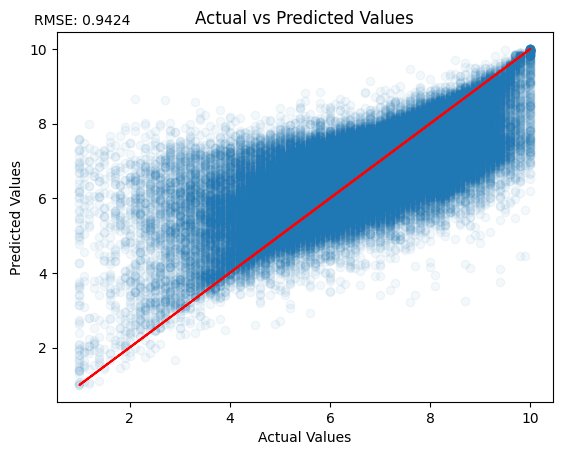

In [11]:

# Assume regr is your trained LinearForestRegressor
predictions = regr.predict(X_test).clip(1, 10)

# Create a scatter plot of predicted vs actual values with transparency
plt.scatter(y_test, predictions, alpha=0.05)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
#Subtitle with score
plt.text(0.05, 1.03, 'RMSE: {:.4f}'.format(rmse), ha='center', va='center', transform=plt.gca().transAxes)

# Plot a line for perfect correlation. This serves as a reference line.
plt.plot(y_test, y_test, 'r')

plt.show()

In [9]:
Yest = regr.predict(X_pred).clip(1, 10)
salida = pd.DataFrame(data={"averageRating": Yest})
salida.index = X_pred.index
salida.to_csv("predicciones/pred42.csv", sep=',',index=True,  index_label='Id')